# Simulate single-channel open and shut intervals

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import sys, math, random
import numpy as np

In [3]:
# Import DCPROGS stuff
from dcpyps.samples import samples
from dcpyps import dcio, dataset, dcplots
from dcpyps import scsim
#from scalcs import scalcslib as scl

### Load mechanism

In [4]:
# LOAD DEMO MECHANISM (C&H82 numerical example).
mec = samples.CH82()
mec.printout(sys.stdout)


class dcpyps.Mechanism
Values of unit rates [1/sec]:
0	From AR  	to AR*    	beta1   	15.0
1	From A2R  	to A2R*    	beta2   	15000.0
2	From AR*  	to AR    	alpha1   	3000.0
3	From A2R*  	to A2R    	alpha2   	500.0
4	From AR  	to R    	k(-1)   	2000.0
5	From A2R  	to AR    	2k(-2)   	4000.0
6	From R  	to AR    	2k(+1)   	100000000.0
7	From AR*  	to A2R*    	k*(+2)   	500000000.0
8	From AR  	to A2R    	k(+2)   	500000000.0
9	From A2R*  	to AR*    	2k*(-2)   	0.66667

Conductance of state AR* (pS)  =      60

Conductance of state A2R* (pS)  =      60

Number of open states = 2
Number of short-lived shut states (within burst) = 2
Number of long-lived shut states (between bursts) = 1
Number of desensitised states = 0

Number of cycles = 1
Cycle 0 is formed of states: A2R*  AR*  AR  A2R  
	forward product = 1.500007500e+16
	backward product = 1.500000000e+16

In [5]:
# Enter:
    # temporal resolution in seconds
tr = 0.00002
#tr = 0.000001
    # critical time interval in seconds
tc = 0.004
    # concentration in Moles
c = 100e-9

In [6]:
# Get Q-matrix for given concentration
mec.set_eff('c', c)

In [7]:
pi = scsim.transition_probability(mec.Q)
print('\nTransition probability:\npi=\n', pi)
picum = np.cumsum(pi,axis=1)
print('\nCummulative transition probability:\npicum=\n', picum)
# calculate mean lifetimes
tmean = -1 / mec.Q.diagonal() # in s
print('\nMean lifetime in each state (ms):\ntmean=\n', tmean*1000)


Transition probability:
pi=
 [[ 0.          0.01639344  0.98360656  0.          0.        ]
 [ 0.00133156  0.          0.          0.99866844  0.        ]
 [ 0.00726392  0.          0.          0.02421308  0.968523  ]
 [ 0.          0.78947368  0.21052632  0.          0.        ]
 [ 0.          0.          1.          0.          0.        ]]

Cummulative transition probability:
picum=
 [[ 0.          0.01639344  1.          1.          1.        ]
 [ 0.00133156  0.00133156  0.00133156  1.          1.        ]
 [ 0.00726392  0.00726392  0.00726392  0.031477    1.        ]
 [ 0.          0.78947368  1.          1.          1.        ]
 [ 0.          0.          1.          1.          1.        ]]

Mean lifetime in each state (ms):
tmean=
 [  3.27868852e-01   1.99733687e+00   4.84261501e-01   5.26315789e-02
   1.00000000e+02]


### Simulate intervals

In [8]:
# Enter simulation parameters:
    # Number of intervals to be simulated
nintmax = 15000
    # open channel amplitude in picoAmpers
opamp = 5
    # initial state
inst = mec.k -1

In [9]:
# Initialise simulation
    # interval and transition counters
nint, ntrns = 0, 0 
    # initial state
inst = mec.k - 1 # unliganded closed state
    # amplitude of initial state
a = opamp if inst < mec.kA else 0
    # length of initial interval
t = - tmean[inst] * math.log(random.random())
    # lists to keep intervals and amplitudes
tints, ampls = [t], [a]

In [10]:
print('\n\tStarting state ', mec.States[inst].name, 
      '\n\ttime interval (ms)=', t*1000, 
      '\n\tamplitude (pA)=', a)


	Starting state  R 
	time interval (ms)= 29.9995326266 
	amplitude (pA)= 0


In [11]:
# Run simulation:
while nint < nintmax-1:

    newst, t, a = scsim.next_state(inst, picum, tmean, mec.kA, opamp)
    ntrns += 1
    if t < tr:
        tints[-1] += t
        a = ampls[-1]
    else:
        if ((a != 0 and ampls[-1] != 0) or (a == 0 and ampls[-1] == 0)):
            tints[-1] += t
        else:
            tints.append(t)
            ampls.append(a)
            nint += 1
    inst = newst
flags = np.zeros((len(tints)), dtype='b')
print('Simulation finished.')

Simulation finished.


In [12]:
print ('\n\t Number of calculated intervals=', len(tints))
print ('\n\t Number of transitions=', ntrns)


	 Number of calculated intervals= 15000

	 Number of transitions= 213967


### Create DCPYPS Single Channel Record object and plot interval histograms

In [13]:
rec = dataset.SCRecord(conc=c, tres=tr, 
    itint=np.array(tints), iampl=np.array(ampls), iprops=flags)
print(rec)



 Data loaded from file: no file name; probably this is simulated record.
Concentration of agonist = 0.100 microMolar
Resolution for HJC calculations = 20.0 microseconds
Critical gap length to define end of group (tcrit) = 27396.536 milliseconds
	(defined so that all openings in a group prob come from same channel)
Initial and final vectors for bursts calculated asin Colquhoun, Hawkes & Srodzinski, (1996, eqs 5.8, 5.11).

Number of resolved intervals = 14998
Number of resolved periods = 14998

Number of open periods = 7499
Mean and SD of open periods = 2.487767098 +/- 2.649372109 ms
Range of open periods from 0.020320127 ms to 24.346908964 ms

Number of shut intervals = 7499
Mean and SD of shut periods = 1260.321725238 +/- 2780.311700785 ms
Range of shut periods from 0.020027868 ms to 27396.536244600 ms
Last shut period = 11991.324705288 ms

Number of bursts = 2
Average length = 4715210.261036036 ms
Range: 932869.949 to 8497550.573 millisec
Average number of openings= 3749.500000000



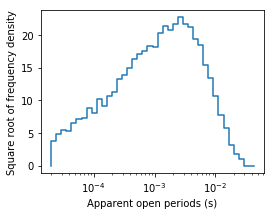

In [14]:
# Plot open time histogram
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
dcplots.xlog_hist_data(ax, rec.opint, rec.tres, shut=False)

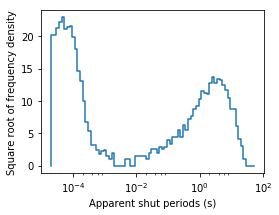

In [15]:
# Plot shut time histogram
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
dcplots.xlog_hist_data(ax, rec.shint, rec.tres, shut=True)